In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 7.1

In [2]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


#### Code 7.2

In [3]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 729.23draws/s]


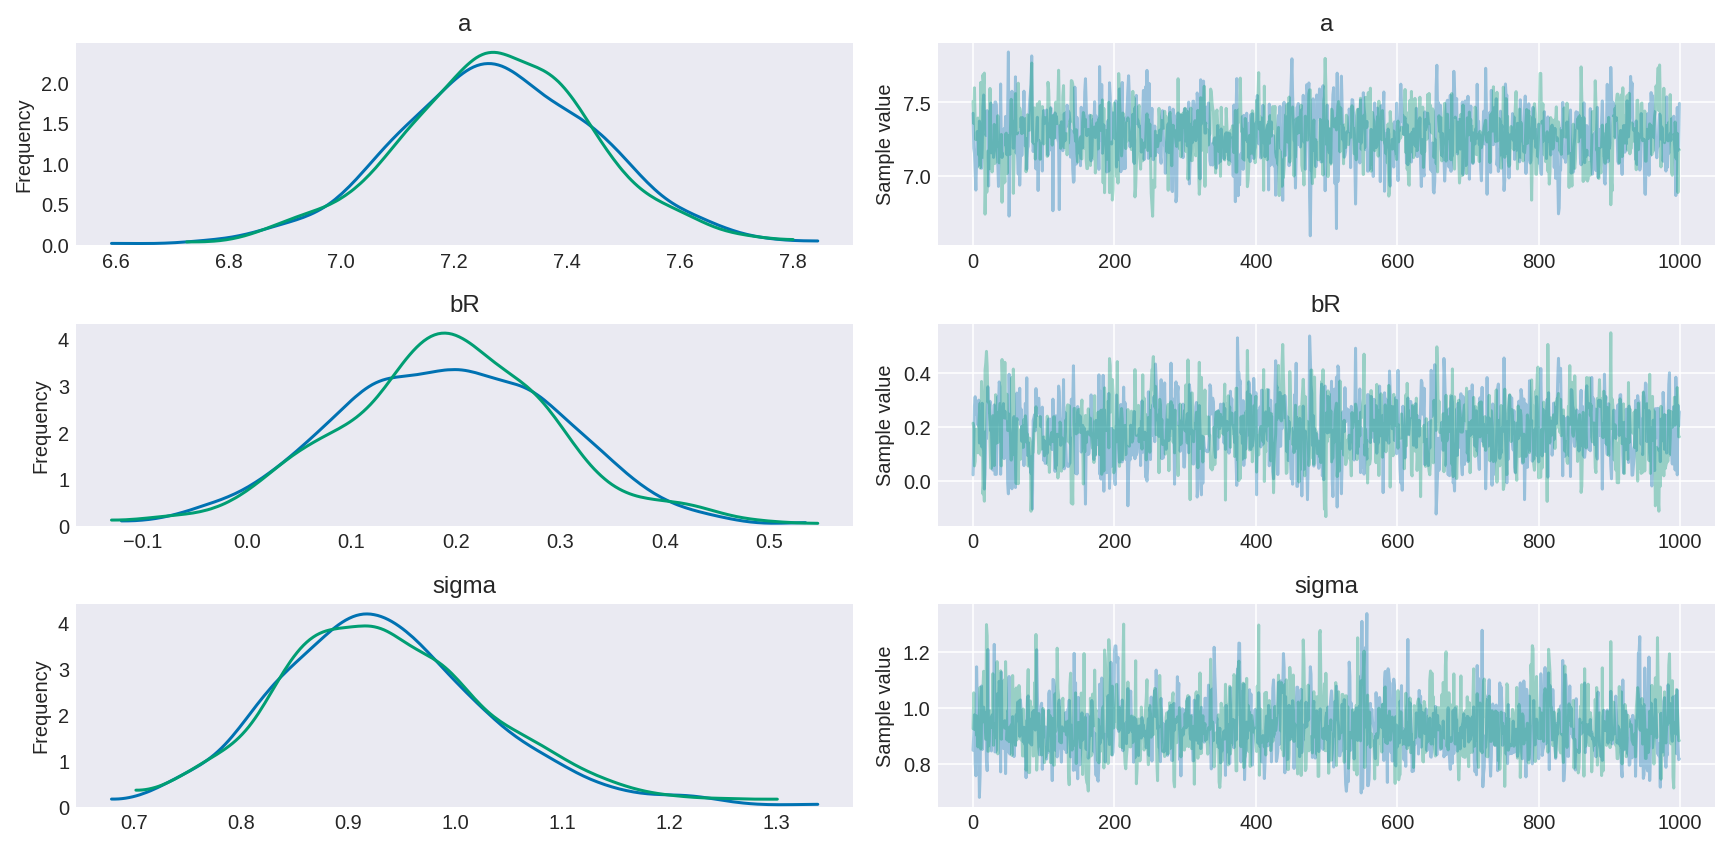

In [4]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [5]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 651.81draws/s]


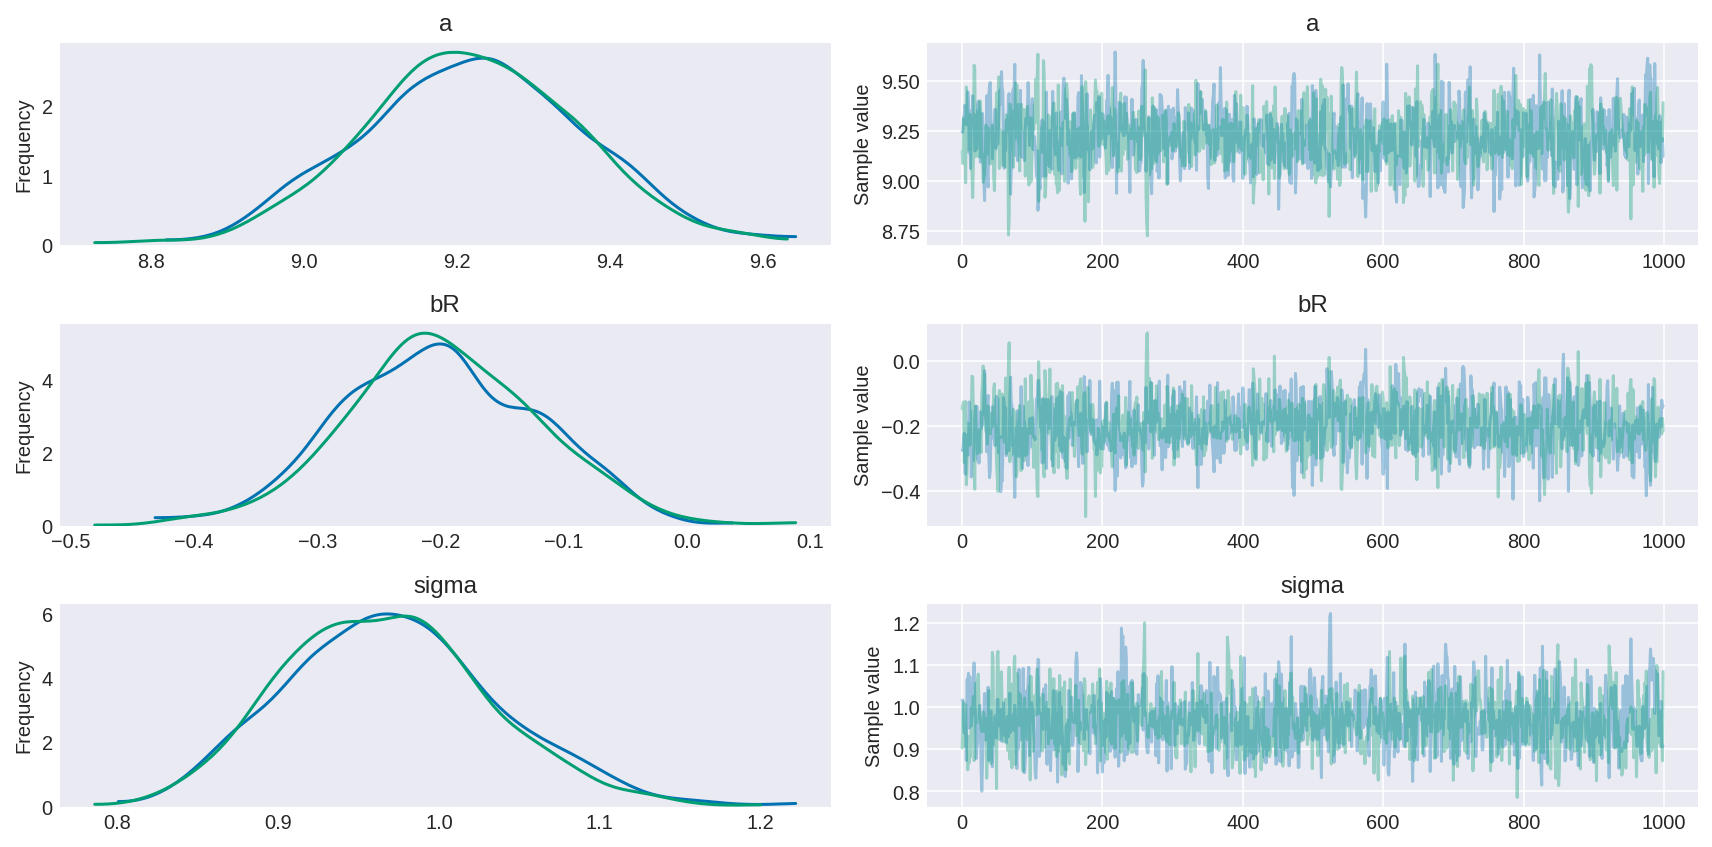

In [6]:
pm.traceplot(trace_7_2_2, varnames);

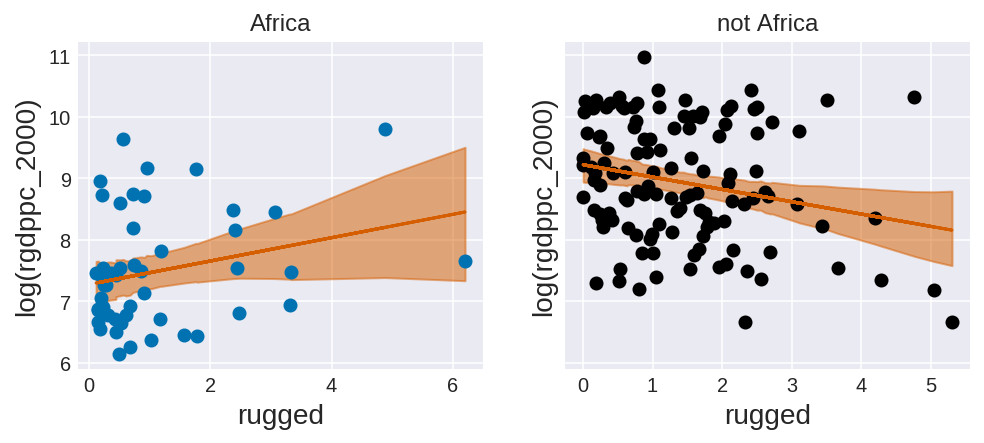

In [7]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'C2')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'C2')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14)
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.5);

#### Code 7.3

In [8]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 840.13draws/s] 


#### Code 7.4

In [9]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 972.27draws/s] 


#### Code 7.5

WAIC values are point estimates and hence is a good idea to include the uncertainty asociated with their estimation when computing weights. PyMC3 uses a Bayesian bootstrapping to do this (read more [here](https://arxiv.org/abs/1704.02030)), and also to compute the standard error (SE) of WAIC/LOO estimates. If you set `bootstrapping = False` weights (and SE) will be computed as in the book.

In [10]:
comp_df = pm.compare({model_7_3 : trace_7_3, 
                      model_7_4 : trace_7_4})

comp_df.loc[:,'model'] = pd.Series(['m7.3', 'm7.4'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7.4,475.92,4.06,0,0.97,14.71,0,1
m7.3,539.49,2.57,63.58,0.03,12.89,14.51,0


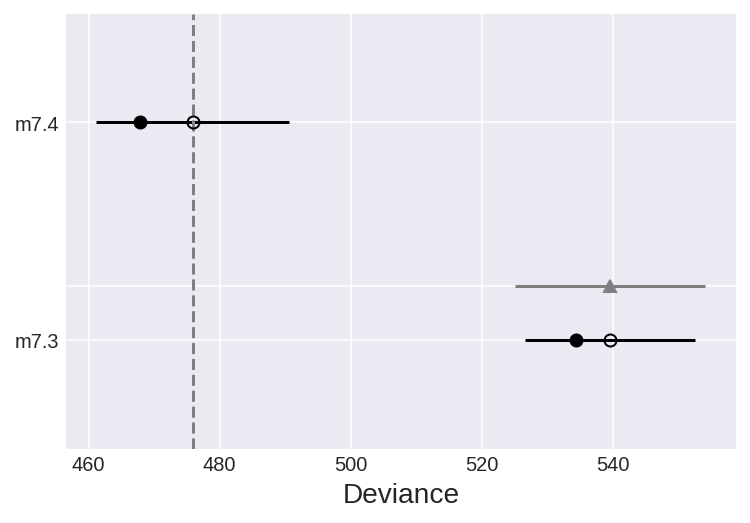

In [11]:
pm.compareplot(comp_df);

#### Code 7.6

Since the link function isn't implemented we have to compute the mean over samples ourselves using a loop.

In [12]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))

for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1 

In [13]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

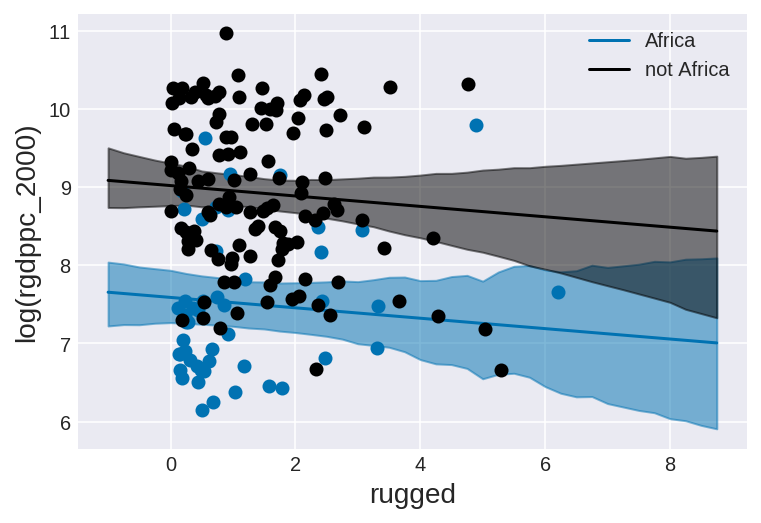

In [14]:
plt.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o',label='')
plt.plot(rugged_seq, mu_mean_Africa, 'C0', label='Africa')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
plt.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko', label='')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k', label='not Africa')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
# plt.annotate('not Africa', xy=(6, 9.5))
# plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14)
plt.xlabel('rugged', fontsize=14);
plt.legend();

#### Code 7.7

In [15]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 838.15draws/s] 


#### Code 7.8

In [16]:
comp_df = pm.compare({model_7_3 : trace_7_3,
                      model_7_4 : trace_7_4,
                      model_7_5 : trace_7_5})


comp_df.loc[:,'model'] = pd.Series(['m7.3', 'm7.4', 'm7.5'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damiano

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7.5,469.16,4.92,0,0.95,14.52,0,1
m7.4,475.92,4.06,6.76,0.05,14.71,5.8,1
m7.3,539.49,2.57,70.33,0,12.89,14.6,0


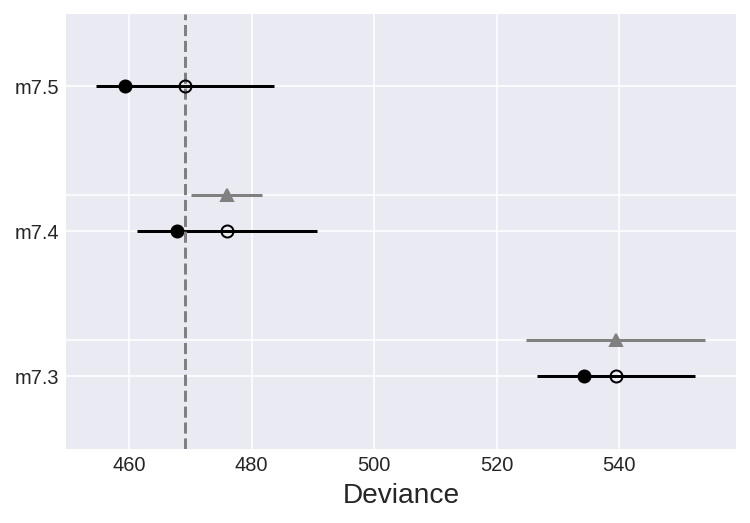

In [17]:
pm.compareplot(comp_df);

#### Code 7.9

In [18]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 785.82draws/s]


#### Code 7.10
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.


In [19]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [20]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

#### Code 7.11

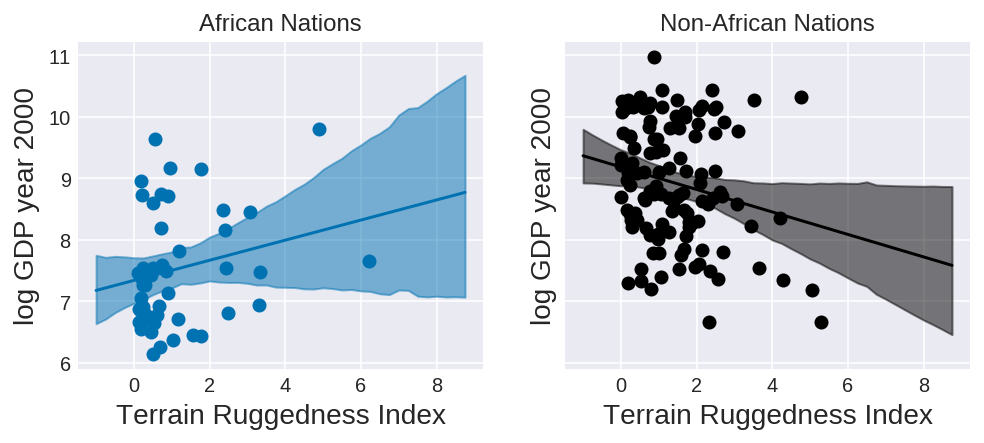

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

#### Code 7.12

In [22]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
pm.summary(trace_7_5b, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.181,0.139,0.004,8.958,9.402,890.665,1.006
bA,-1.843,0.215,0.006,-2.165,-1.477,1032.633,1.001
bR,-0.183,0.076,0.002,-0.302,-0.059,960.368,1.003
bAR,0.346,0.127,0.004,0.148,0.548,1021.303,1.000
sigma,0.950,0.053,0.001,0.868,1.032,1858.772,1.000


#### Code 7.13

In [23]:
gamma_Africa = trace_7_5b['bR'] + trace_7_5b['bAR'] * 1
gamma_notAfrica = trace_7_5b['bR']

#### Code 7.14

In [24]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

Gamma within Africa: 0.16
Gamma outside Africa: -0.18


#### Code 7.15

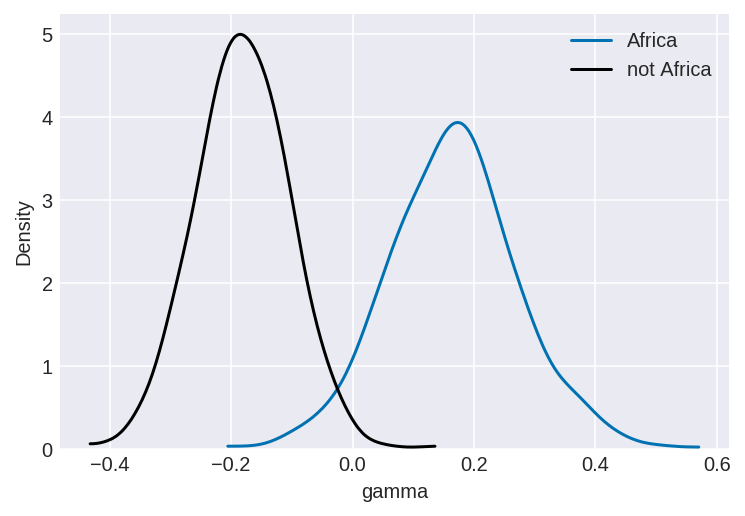

In [25]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5.25)
pm.kdeplot(gamma_Africa, color='C0', ax=ax, label='Africa')
pm.kdeplot(gamma_notAfrica, color='k', ax=ax, label='not Africa');
ax.legend();

#### Code 7.16

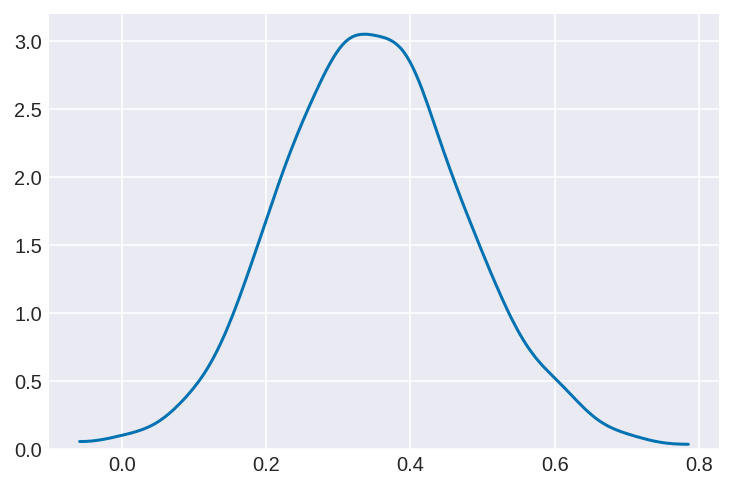

In [26]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
pm.kdeplot(diff);
# plt.hist(diff, bins=len(diff));
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [27]:
sum(gamma_Africa<gamma_notAfrica)/gamma_Africa.shape[0]

0.003

In [28]:
sum(diff < 0) / len(diff)

0.003

#### Code 7.17
Plot the reverse interpretation: The influence of being in Africa depends upon terrain ruggedness.

This places `cont_africa` on the horizontal axis, while using different lines for different values of `rugged`.

In [29]:
# Get min and max rugged values.
q_rugged = [0, 0]
q_rugged[0] = np.min(dd.rugged)
q_rugged[1] = np.max(dd.rugged)

In [30]:
q_rugged

[0.003, 6.202000000000001]

In [31]:
mu_ruggedlo = np.zeros((2, len(trace_7_5b['bR'])))
mu_ruggedhi = np.zeros((2, len(trace_7_5b['bR'])))
mu_ruggedhi.shape

(2, 2000)

In [32]:
# Compute lines and confidence intervals.
# Since the link function isn't implemented we have to again compute the mean over samples ourselves using a loop.
mu_ruggedlo = np.zeros((2, len(trace_7_5b['bR'])))
mu_ruggedhi = np.zeros((2, len(trace_7_5b['bR'])))
# Iterate over outside Africa (0) and inside Africa (1).
for iAfri in range(0,2):
    mu_ruggedlo[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[0] + \
                              trace_7_5b['bAR'] * q_rugged[0] * iAfri + \
                              trace_7_5b['bA'] * iAfri
    mu_ruggedhi[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[1] + \
                              trace_7_5b['bAR'] * q_rugged[1] * iAfri + \
                              trace_7_5b['bA'] * iAfri

Each row in mu_ruggedlo is the estimate of log-GDP when not in Africa [row=0] and in Africa [row=1] in the case of low ruggdeness. The same is true for mu_ruggedhi but for high ruggdeness

In [33]:
mu_ruggedlo_mean = np.mean(mu_ruggedlo, axis=1)
mu_hpd_ruggedlo = pm.hpd(mu_ruggedlo.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_ruggedhi_mean = np.mean(mu_ruggedhi, axis=1)
mu_hpd_ruggedhi = pm.hpd(mu_ruggedhi.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03

In [34]:
# Source http://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  # outward by 5 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

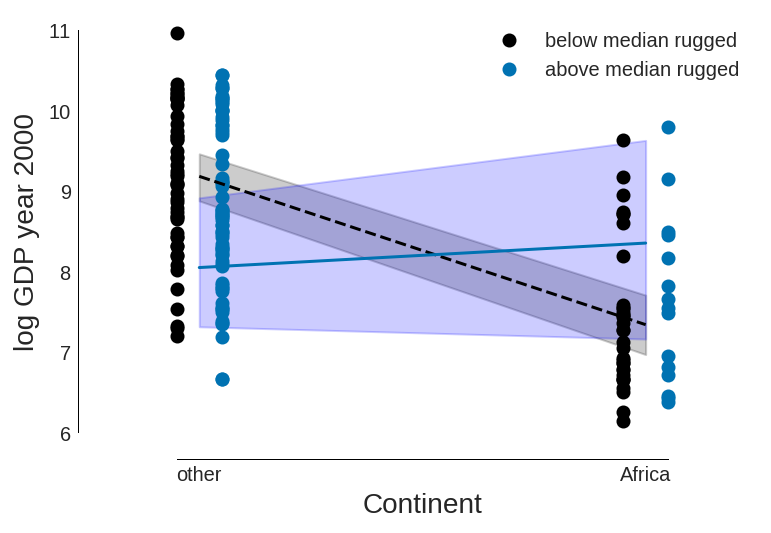

In [35]:
# Plot it all, splitting points at median
med_r = np.median(dd.rugged)
# Use list comprehension to split points at median
# 
# all this is just to split the data into rugged (>median_rugged) and not rugged (<median_rugged)
# the 0.05 is also used as an offset for the x-axis of the plot
# so if a country is in Africa and it has rugged terrain will have a cont_africa_ox value of 1.05 and 
# 0.95 if it doesn't have rough terain. Similarly if a country is not in Africa and it has rough terrain 
# it will have a cont_africa_ox value of 0.05 and -0.05 otherwise.
ox = [0.05 if x > med_r else -0.05 for x in dd.rugged]
idxk = [i for i,x in enumerate(ox) if x == -0.05]
idxb = [i for i,x in enumerate(ox) if x == 0.05]
cont_africa_ox = dd.cont_africa + ox
plt.plot(cont_africa_ox[dd.cont_africa.index[idxk]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxk]]), 'ko',
        label = 'below median rugged')
plt.plot(cont_africa_ox[dd.cont_africa.index[idxb]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxb]]), 'C0o',
        label='above median rugged')
# plots of change in mean log-GDP for a nation with min/max rugedness being moved to Africa
plt.plot([0, 1], mu_ruggedlo_mean, 'k--')
plt.plot([0, 1], mu_ruggedhi_mean, 'C0')
plt.fill_between([0, 1], mu_hpd_ruggedlo[:,0], mu_hpd_ruggedlo[:,1], color='k', alpha=0.2)
plt.fill_between([0, 1], mu_hpd_ruggedhi[:,0], mu_hpd_ruggedhi[:,1], color='b', alpha=0.2)
plt.ylabel('log GDP year 2000', fontsize=14);
plt.xlabel('Continent', fontsize=14)
axes = plt.gca()
axes.set_xlim([-0.25, 1.25])
axes.set_ylim([5.8, 11.2])
axes.set_xticks([0, 1])
axes.set_xticklabels(['other', 'Africa'], fontsize=12)
axes.set_facecolor('white')
adjust_spines(axes, ['left', 'bottom'])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(0.5)
axes.spines['left'].set_linewidth(0.5)
axes.spines['bottom'].set_color('black')
axes.spines['left'].set_color('black');
plt.legend();

Now look at the regression lines. The black dashed line and shaded confidence region show the expected reduction in log-GDP when we take a nation with minimum terrain ruggedness (0.003) and change its continent. For low ruggedness, the expected reduction in log-GDP is about 2 full points. The blue regression line and shaded region are instead the expected change for an imaginary nation with maximum observed terrain ruggedness (6.2). Now changing continent has almost no expected effect—the line does slope upwards a tiny amount, but the wide shaded interval should prevent us from getting excited about that fact. For a nation with very high ruggedness, there is almost no negative effect on GDP of being in Africa.

#### Code 7.18

In [36]:
d = pd.read_csv('Data/tulips.csv', sep=';', header=0)
print(d.info())
print(d.head())
print(d.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 944.0+ bytes
None
  bed  water  shade  blooms
0   a      1      1    0.00
1   a      1      2    0.00
2   a      1      3  111.04
3   a      2      1  183.47
4   a      2      2   59.16
          water     shade      blooms
count  27.00000  27.00000   27.000000
mean    2.00000   2.00000  128.993704
std     0.83205   0.83205   92.683923
min     1.00000   1.00000    0.000000
25%     1.00000   1.00000   71.115000
50%     2.00000   2.00000  111.040000
75%     3.00000   3.00000  190.300000
max     3.00000   3.00000  361.660000


#### Code 7.19

In [37]:
with pm.Model() as model_7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 650.65draws/s]


In [38]:
with pm.Model() as model_7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade + bWS*d.water*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:12<00:00, 326.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [39]:
map_7_6 = pm.find_MAP(model=model_7_6)
map_7_6

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -175.26, ||grad|| = 0.0011502: 100%|██████████| 24/24 [00:00<00:00, 1842.71it/s]  


{'a': array(44.02992948),
 'bW': array(76.44616379),
 'bS': array(-34.77920715),
 'sigma_interval__': array(19.99194662),
 'sigma': array(100.),
 'mu': array([ 85.69688612,  50.91767897,  16.13847183, 162.14304991,
        127.36384277,  92.58463562, 238.58921371, 203.81000656,
        169.03079941,  85.69688612,  50.91767897,  16.13847183,
        162.14304991, 127.36384277,  92.58463562, 238.58921371,
        203.81000656, 169.03079941,  85.69688612,  50.91767897,
         16.13847183, 162.14304991, 127.36384277,  92.58463562,
        238.58921371, 203.81000656, 169.03079941])}

In [40]:
map_7_7 = pm.find_MAP(model=model_7_7)
map_7_7

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -170.17, ||grad|| = 0.012971: 100%|██████████| 54/54 [00:00<00:00, 1566.22it/s]    


{'a': array(-84.31089711),
 'bW': array(151.00906588),
 'bS': array(34.9836048),
 'bWS': array(-39.50317218),
 'sigma_interval__': array(-0.15013976),
 'sigma': array(46.253541),
 'mu': array([ 62.17860138,  57.659034  ,  53.13946661, 173.68449507,
        129.66175551,  85.63901594, 285.19038877, 201.66447702,
        118.13856527,  62.17860138,  57.659034  ,  53.13946661,
        173.68449507, 129.66175551,  85.63901594, 285.19038877,
        201.66447702, 118.13856527,  62.17860138,  57.659034  ,
         53.13946661, 173.68449507, 129.66175551,  85.63901594,
        285.19038877, 201.66447702, 118.13856527])}

#### Code 7.20
You can use the modified Powell's method if it fails with BFGS (default MAP estimate)

In [41]:
from scipy import optimize
map_7_6 = pm.find_MAP(model=model_7_6, method='Powell')
map_7_6

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:501: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -170.22, ||grad|| = 0.11488: 100%|██████████| 224/224 [00:00<00:00, 1856.10it/s]        


{'a': array(88.0937284),
 'bW': array(58.99402102),
 'bS': array(-38.86994299),
 'sigma_interval__': array(0.35657868),
 'sigma': array(58.82119774),
 'mu': array([108.21780642,  69.34786343,  30.47792044, 167.21182744,
        128.34188445,  89.47194146, 226.20584846, 187.33590547,
        148.46596248, 108.21780642,  69.34786343,  30.47792044,
        167.21182744, 128.34188445,  89.47194146, 226.20584846,
        187.33590547, 148.46596248, 108.21780642,  69.34786343,
         30.47792044, 167.21182744, 128.34188445,  89.47194146,
        226.20584846, 187.33590547, 148.46596248])}

In [42]:
map_7_7 = pm.find_MAP(model=model_7_7, method='Powell')
map_7_7

logp = -176.57, ||grad|| = 1.3111: 100%|██████████| 640/640 [00:00<00:00, 1765.00it/s]         


{'a': array(98.23420593),
 'bW': array(53.39247436),
 'bS': array(-41.50750244),
 'bWS': array(1.57395991),
 'sigma_interval__': array(0.40658167),
 'sigma': array(60.0267945),
 'mu': array([111.69313777,  71.75959524,  31.82605271, 166.65957204,
        128.29998941,  89.94040679, 221.62600631, 184.84038359,
        148.05476088, 111.69313777,  71.75959524,  31.82605271,
        166.65957204, 128.29998941,  89.94040679, 221.62600631,
        184.84038359, 148.05476088, 111.69313777,  71.75959524,
         31.82605271, 166.65957204, 128.29998941,  89.94040679,
        221.62600631, 184.84038359, 148.05476088])}

#### Code 7.21
`conftab` is not implemented in PyMC3, something similar is to use `summary()`

In [43]:
pm.summary(trace_7_6, varnames=['a', 'bW', 'bS', 'sigma'])['mean']

a        51.871096
bW       76.615224
bS      -38.412713
sigma    64.392075
Name: mean, dtype: float64

In [44]:
pm.summary(trace_7_7, varnames=['a', 'bW', 'bS', 'sigma', 'bWS'])['mean']

a        -71.808323
bW       144.782047
bS        29.513428
sigma     52.561797
bWS      -36.836430
Name: mean, dtype: float64

#### Code 7.22

In [45]:
comp_df = pm.compare({model_7_6 : trace_7_6,
                      model_7_7 : trace_7_7})

comp_df.loc[:,'model'] = pd.Series(['m7.6', 'm7.7'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7.7,293.93,4.12,0,1,7.1,0,1
m7.6,303.4,3.43,9.46,0,6.71,3.68,1


#### 7.23
Center and re-estimate

In [46]:
d.shade_c = d.shade - np.mean(d.shade)
d.water_c = d.water - np.mean(d.water)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


#### 7.24
No interaction.

In [47]:
with pm.Model() as model_7_8:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_8 = pm.sample(1000, tune=1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1086.17draws/s]


Interaction.

In [48]:
with pm.Model() as model_7_9:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c + bWS*d.water_c*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_9 = pm.sample(1000, tune=1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'bWS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 929.22draws/s] 


In [49]:
map_7_8 = pm.find_MAP(model=model_7_8)
map_7_8

logp = -196.39, ||grad|| = 0.32474: 100%|██████████| 16/16 [00:00<00:00, 1749.04it/s]  


{'a': array(124.38684955),
 'bW': array(71.81213462),
 'bS': array(-39.413174),
 'sigma_interval__': array(48.62145626),
 'sigma': array(100.),
 'mu': array([ 91.98788894,  52.57471493,  13.16154093, 163.80002355,
        124.38684955,  84.97367554, 235.61215817, 196.19898417,
        156.78581016,  91.98788894,  52.57471493,  13.16154093,
        163.80002355, 124.38684955,  84.97367554, 235.61215817,
        196.19898417, 156.78581016,  91.98788894,  52.57471493,
         13.16154093, 163.80002355, 124.38684955,  84.97367554,
        235.61215817, 196.19898417, 156.78581016])}

In [50]:
map_7_9 = pm.find_MAP(model=model_7_9)
map_7_9

logp = -201.51, ||grad|| = 0.32861: 100%|██████████| 18/18 [00:00<00:00, 1309.22it/s]  


{'a': array(124.3869317),
 'bW': array(71.81252725),
 'bS': array(-39.4133895),
 'bWS': array(-48.78655415),
 'sigma_interval__': array(50.89448125),
 'sigma': array(100.),
 'mu': array([ 43.20123979,  52.57440445,  61.9475691 , 163.80032119,
        124.3869317 ,  84.9735422 , 284.39940259, 196.19945895,
        107.9995153 ,  43.20123979,  52.57440445,  61.9475691 ,
        163.80032119, 124.3869317 ,  84.9735422 , 284.39940259,
        196.19945895, 107.9995153 ,  43.20123979,  52.57440445,
         61.9475691 , 163.80032119, 124.3869317 ,  84.9735422 ,
        284.39940259, 196.19945895, 107.9995153 ])}

#### 7.25

In [51]:
map_7_7['a'] + map_7_7['bW'] * 2 + map_7_7['bS'] * 2 + map_7_7['bWS'] * 2 * 2

128.29998941417296

#### 7.26

In [52]:
map_7_9['a'] + map_7_9['bW'] * 0 + map_7_9['bS'] * 0 + map_7_9['bWS'] * 0 * 0

124.38693169605965

#### 7.27

In [53]:
varnames = ['a', 'bW', 'bS', 'bWS', 'sigma']
pm.summary(trace_7_9, varnames, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,128.173,10.335,0.223,111.858,144.942,1919.902,1.004
bW,74.814,12.595,0.301,54.585,93.686,1765.202,1.000
bS,-41.166,12.212,0.304,-59.814,-21.324,1875.284,1.000
bWS,-51.921,14.625,0.332,-74.012,-27.673,2152.036,1.000
sigma,51.935,8.072,0.212,39.658,64.264,1329.693,1.000


• The estimate a , α, is the expected value of blooms when both water and shade are at their average values. Their average values are both zero (0), because they were centered before fitting the model.

• The estimate bW , β W , is the expected change in blooms when water increases by one unit and shade is at its average value (of zero). This parameter does not tell you the expected rate of change for any other value of shade. This estimate suggests that when shade is at its average value, increasing water is highly beneficial to
blooms.

• The estimate bS , β S , is the expected change in blooms when shade increases by one unit and water is at its average value (of zero). This parameter does not tell you the expected rate of change for any other value of water. This estimate suggests that when water is at its average value, increasing shade is highly detrimental to
blooms.

• The estimate bWS , β WS , is the interaction effect. Like all linear interactions, it can be explained in more than one way. First, the estimate tells us the expected change in the influence of water on blooms when increasing shade by one unit. Second, it tells us the expected change in the influence of shade on blooms when increasing water by one unit.

So why is the interaction estimate, bWS , negative? The short answer is that water and shade have opposite effects on blooms, but that each also makes the other more important to the outcome. If you don’t see how to read that from the number −52, you are in good company. And that’s why the best thing to do is to plot implied predictions.

#### 7.28

We have to replace the `link` function with a loop.

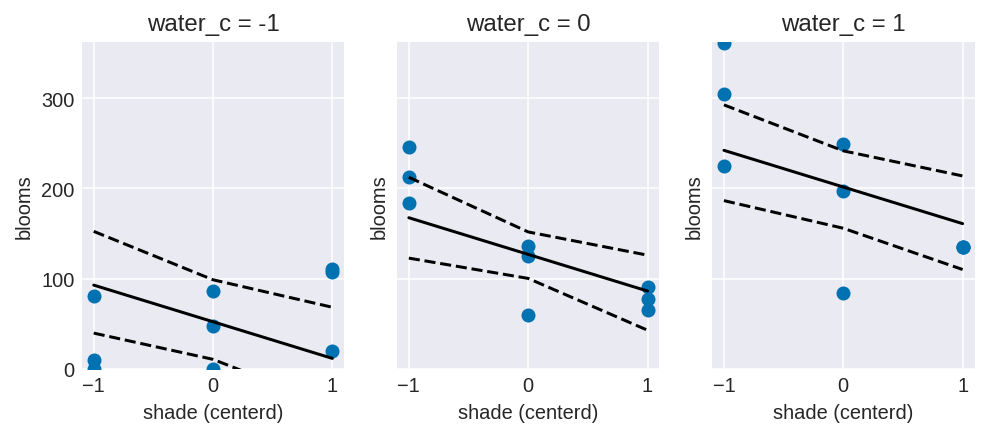

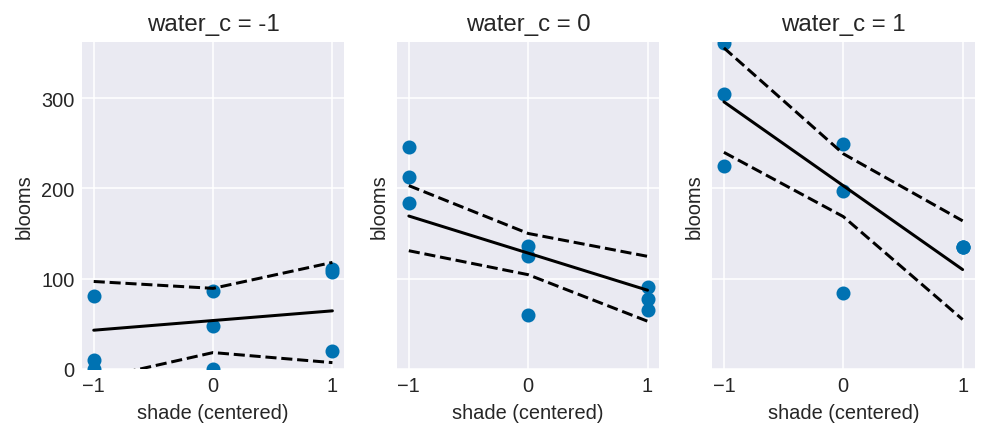

In [54]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_8['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_8['a'] + trace_7_8['bW'] * w + trace_7_8['bS'] * iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centerd)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_9['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_9['a'] + trace_7_9['bW'] * w + trace_7_9['bS'] * iSeq + trace_7_9['bWS'] * w * iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centered)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

What is going on here? The likely explanation for these results is that tulips need both water and light to produce blooms. At low water levels, shade can’t have much of an effect, because the tulips don’t have enough water to produce blooms anyway. At higher water levels, shade can matter more, because the tulips have enough water to produce some blooms.
 
At very high water levels, water is no longer limiting the blooms very much, and so shade can have a much more dramatic impact on the outcome. The same explanation works symmetrically for shade. If there isn’t enough light, then more water hardly helps. You could remake the figure above with water on the horizontal axes and shade level varied from left to right, if you’d like to visualize the model predictions that way.

Let's remake the plots with water on abscissa while varying shade levels from left to right.

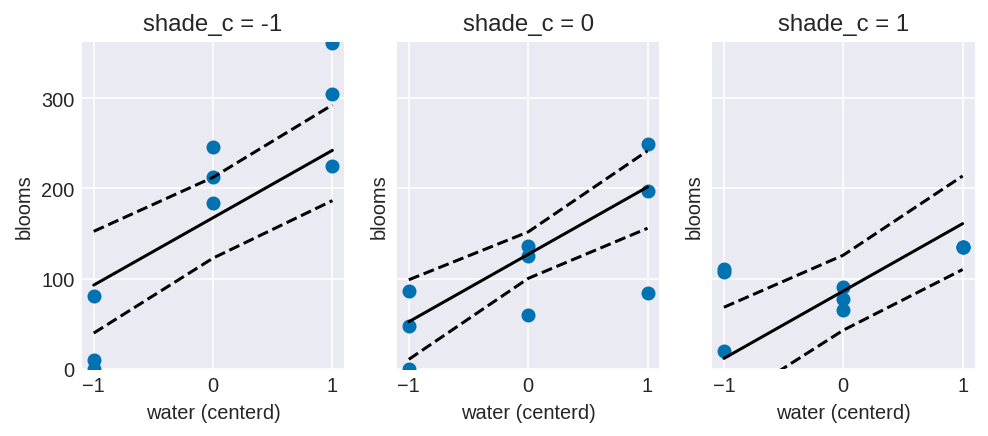

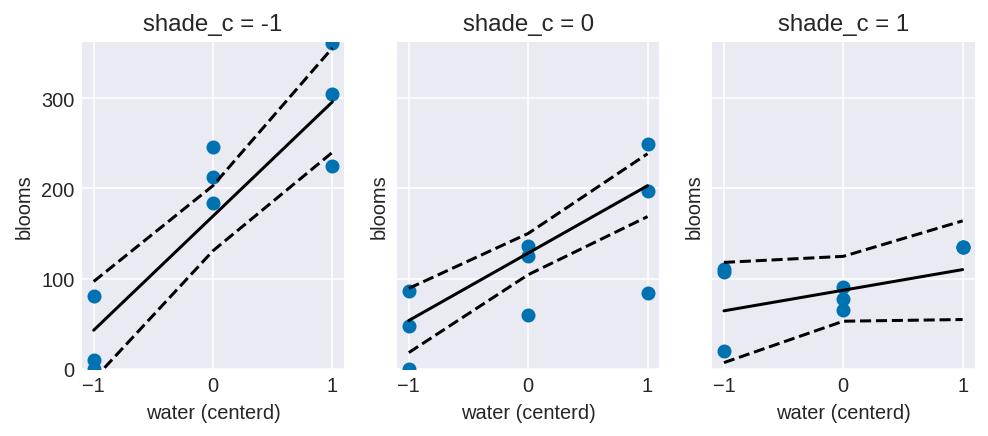

In [55]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_8['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_s[x] = trace_7_8['a'] + trace_7_8['bW'] * iSeq + trace_7_8['bS'] * s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = pm.hpd(mu_s.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], 'k--')
    ax.plot(water_seq, mu_hpd_s.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = {:d}'.format(s))
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_9['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'C0o')
    for x, iSeq in enumerate(water_seq):
        mu_s[x] = trace_7_9['a'] + trace_7_9['bW'] * iSeq + trace_7_9['bS'] * s + trace_7_9['bWS'] * iSeq * s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = pm.hpd(mu_s.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], 'k--')
    ax.plot(water_seq, mu_hpd_s.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = {:d}'.format(s))
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

When there is no interaction the slope is the same across all three plots (top row), showing a general reduction with increasing shade. For the interaction (bottom row) we can see a huge increase in blooms for the lowest amount of shade as we increase water. This effect is reduced by increasing shade to average levels and in the last plot increasing water has a minimum effect when there is lots of shade.

#### 7.29

In [56]:
m_7_x = smf.ols('blooms ~ shade + water + shade * water', data=d).fit()

#### 7.30

In [57]:
m_7_x = smf.ols('blooms ~ shade * water', data=d).fit()

#### 7.31

In [58]:
m_7_x = smf.ols('blooms ~ shade * water - water', data=d).fit()

#### 7.32

In [59]:
m_7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

#### 7.33
Not sure how this one works

In [60]:
from patsy import dmatrix
x, y, z = 1, 1, 1
d_matrix = dmatrix('~ x * y * w')
d_matrix.design_info.column_names 

['Intercept', 'x', 'y', 'x:y', 'w', 'x:w', 'y:w', 'x:y:w']

In [61]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
